<a href="https://colab.research.google.com/github/newstage75/ShogiAI/blob/main/ch04/train_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ディープラーニングフレームワーク

 ## ランタイムのタイプの確認
「ランタイム」－「ランタイムのタイプを変更」から、「ハードウェア アクセラレータ」が「GPU」になっていることを確認します。なっていない場合、「GPU」に変更します。

## 割り当てられたGPUとCUDAバージョンの確認

In [1]:
!nvidia-smi

Sat Jun 11 02:08:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## PyTorchの基本

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### ハイパーパラメータ

In [3]:
learning_rate = 0.001
batch_size = 64
epochs = 5

In [4]:
# データセット
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
training_data = datasets.MNIST(
    'data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(
    'data', train=False, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
# データローダ
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size)

In [6]:
# デバイス(CPUを使用する場合は、use_cudaをFalseにする)
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

### ニューラルネットワークの定義

PyTorchでは、ここで使用したもの以外にも、様々な種類の層や活性化関数を使用することができる。

必要なときに、PyTorchの公式ドキュメントで調べると目的のものをみつけることができる。

In [7]:
# ニューラルネットワーク
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        output = self.fc2(x)
        return output

### モデルのインスタンス化とデバイスへの転送

In [8]:
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
# 損失関数
loss_fn = nn.CrossEntropyLoss()

### オプティマイザ

In [10]:
# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
# 指定エポック数だけ繰り返す
for t in range(epochs):
    # 訓練ループ
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)

        # 順伝播
        output = model(data)
        # 損失計算
        loss = loss_fn(output, target)
        
        # 誤差逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 一定間隔ごとに訓練損失を表示
        if (batch_idx + 1) % 100 == 0:
            print('epoch: {}, steps: {}/{}, train loss: {:.6f}'.format(
                t + 1,
                batch_idx + 1, len(train_dataloader),
                loss.item()
                ))

    # エポックの終わりにテストデータすべてを使用して評価する
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            correct += (output.argmax(1) == target).type(torch.float).sum().item()
            
    print('epoch: {}, test loss: {:.6f}, test accuracy: {:.6f}'.format(
        t + 1,
        test_loss / len(test_dataloader),
        correct / len(test_dataloader.dataset)
        ))

epoch: 1, steps: 100/938, train loss: 2.204995
epoch: 1, steps: 200/938, train loss: 2.110811
epoch: 1, steps: 300/938, train loss: 1.970357
epoch: 1, steps: 400/938, train loss: 1.669632
epoch: 1, steps: 500/938, train loss: 1.330057
epoch: 1, steps: 600/938, train loss: 0.883598
epoch: 1, steps: 700/938, train loss: 0.673502
epoch: 1, steps: 800/938, train loss: 0.613941
epoch: 1, steps: 900/938, train loss: 0.381267
epoch: 1, test loss: 0.496445, test accuracy: 0.879000
epoch: 2, steps: 100/938, train loss: 0.715485
epoch: 2, steps: 200/938, train loss: 0.460027
epoch: 2, steps: 300/938, train loss: 0.564143
epoch: 2, steps: 400/938, train loss: 0.474449
epoch: 2, steps: 500/938, train loss: 0.459902
epoch: 2, steps: 600/938, train loss: 0.392849
epoch: 2, steps: 700/938, train loss: 0.377766
epoch: 2, steps: 800/938, train loss: 0.601484
epoch: 2, steps: 900/938, train loss: 0.246781
epoch: 2, test loss: 0.335386, test accuracy: 0.904800
epoch: 3, steps: 100/938, train loss: 0.3107

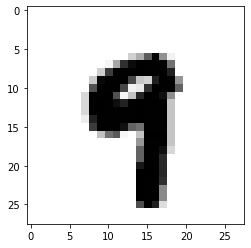

In [28]:
import matplotlib.pyplot as plt
test_index = 575
data = test_data[test_index][0]
plt.imshow(data.reshape((28, 28)), cmap='gray_r')

In [29]:
test_data[test_index][1]

9

In [30]:
model.eval()
with torch.no_grad():
  x = data.unsqueeze(0).to(device)
  logits = model(x)
  pred = torch.softmax(logits, 1).squeeze().cpu()

In [31]:
pred

tensor([9.2944e-07, 4.8123e-06, 1.1915e-06, 9.7562e-04, 5.1736e-02, 2.6219e-03,
        1.7781e-06, 2.7902e-03, 5.9128e-03, 9.3596e-01])

<BarContainer object of 10 artists>

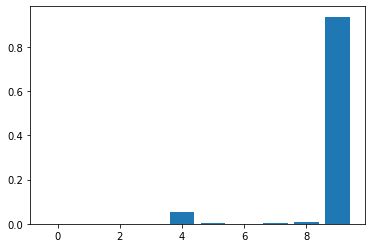

In [32]:
plt.bar(range(10), pred)